<a href="https://colab.research.google.com/github/sg2083/independent_study/blob/main/Sentiment_analysis_25_03_wip.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sentiment Analysis of Stock-Related News & Posts and Predicting Stock Market Prices

### Introduction
The stock market is highly influenced by investor sentiment, which is often reflected in news articles, social media discussions, and online forums. This study focuses on analyzing the sentiment of stock-related posts from multiple sources, including Reddit, NewsAPI, and historical stock prices.

The goal is to determine whether online sentiment correlates with stock price movements and if it can be used as a predictive feature for stock performance.

## Research Questions
1. Does investor sentiment expressed in Reddit posts and news articles correlate with stock price movements for Tesla?
2. Can sentiment data extracted from online platforms be used to predict stock price trends in the short term?
3. What is the relative significance of different sentiment sources (Reddit vs. NewsAPI) in predicting stock market performance?
4. How does sentiment change in response to major news events, and does this sentiment shift correlate with subsequent stock price movements?

##Hypotheses
>**H1**:There is a significant positive correlation between positive sentiment in Reddit posts/news articles and an increase in Tesla's stock price.<br>
**H2**: Negative sentiment in Reddit posts/news articles is significantly correlated with a decrease in Tesla's stock price.<br>
**H3**: Sentiment data from Reddit is more predictive of short-term stock price fluctuations than sentiment data from news articles.<br>
**H4**: Major news events (e.g., product launches, regulatory announcements) cause a significant shift in sentiment, which is reflected in short-term stock price movements.

## Literature Review
The study by Nti, Adekoya, and Weyori (2020) investigates how public sentiment, derived from web news, Twitter, Google Trends, and forum discussions, influences stock market predictions. Using sentiment analysis with an Artificial Neural Network (ANN) model, the authors predict stock prices on the Ghana Stock Exchange (GSE) over time frames of 1 to 90 days. They find that combining multiple data sources improves prediction accuracy, with the highest accuracy (70.66–77.12%) achieved from a combined dataset. The study highlights a strong link between stock market behavior and social media, suggesting that sentiment data from online platforms can help investors predict future stock price movements and make better investment decisions.
link: https://sciendo.com/article/10.2478/acss-2020-0004

## How its different from whats already been done
Event-Driven Sentiment Evolution and Its Impact on Stock Price Prediction

### Data
The data for this study is collected from three primary sources: **Reddit, NewsAPI, and stock market data**. Reddit posts related to **Tesla** stock are retrieved using praw library from financial discussion subreddits like r/wallstreetbets, capturing post titles and timestamps. News articles mentioning Tesla are obtained via NewsAPI, extracting headlines, publication dates, and sources. Historical stock price data is being sourced from Yahoo Finance api, including daily open, high, low, close prices, trading volume, and other financial indicators.

Since these datasets originate from different platforms, they contain varying timestamp formats, time zones, and missing values, requiring careful preprocessing and merging to align sentiment data with stock price movements for further analysis.

### Data Preprocessing
The collected data is being cleaned and standardized before merging. Steps include:

1. Date Format Standardization

  * Convert timestamps from different time zones to UTC
  * Convert stock market timestamps (which include hours/minutes) to date-only format

2. Column Renaming for Clarity

  * Title → title_reddit (for Reddit)
  * Title → title_news (for NewsAPI)
  
  This prevents column name conflicts

3. Handling Missing Data

  * Some dates lack both Reddit posts and news articles
  * Missing values must be carefully handled to avoid bias

4. Merging Data

  Outer join used to keep all records from Reddit, NewsAPI, and stock price data Ensures no loss of important data points Note: Since data comes from multiple sources, preprocessing is still in progress to handle scattered and missing data.

In [51]:
# @title Importing required libraries
!pip install newsapi-python
!pip install praw
!pip install finnhub-python

import yfinance as yf
from newsapi import NewsApiClient
import praw
from datetime import datetime
import pandas as pd
from nltk.sentiment import SentimentIntensityAnalyzer
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
import statsmodels.api as sm
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [52]:
# @title Fetching stock history data for Tesla stocks
tesla = yf.Ticker("TSLA")
tesla_data = tesla.history(period="1y")
print(tesla_data.head())

                                 Open        High         Low       Close  \
Date                                                                        
2024-03-25 00:00:00-04:00  168.759995  175.240005  168.729996  172.630005   
2024-03-26 00:00:00-04:00  178.580002  184.250000  177.380005  177.669998   
2024-03-27 00:00:00-04:00  181.410004  181.910004  176.000000  179.830002   
2024-03-28 00:00:00-04:00  177.449997  179.570007  175.300003  175.789993   
2024-04-01 00:00:00-04:00  176.169998  176.750000  170.210007  175.220001   

                              Volume  Dividends  Stock Splits  
Date                                                           
2024-03-25 00:00:00-04:00   74228600        0.0           0.0  
2024-03-26 00:00:00-04:00  113186200        0.0           0.0  
2024-03-27 00:00:00-04:00   81804000        0.0           0.0  
2024-03-28 00:00:00-04:00   77654800        0.0           0.0  
2024-04-01 00:00:00-04:00   81562100        0.0           0.0  


In [53]:
# Save tesla_data to a CSV file
tesla_data.to_csv('tesla_data.csv')

# Read the CSV file back into a DataFrame named tesla_data
tesla_data = pd.read_csv('tesla_data.csv')
print(tesla_data.head())


                        Date        Open        High         Low       Close  \
0  2024-03-25 00:00:00-04:00  168.759995  175.240005  168.729996  172.630005   
1  2024-03-26 00:00:00-04:00  178.580002  184.250000  177.380005  177.669998   
2  2024-03-27 00:00:00-04:00  181.410004  181.910004  176.000000  179.830002   
3  2024-03-28 00:00:00-04:00  177.449997  179.570007  175.300003  175.789993   
4  2024-04-01 00:00:00-04:00  176.169998  176.750000  170.210007  175.220001   

      Volume  Dividends  Stock Splits  
0   74228600        0.0           0.0  
1  113186200        0.0           0.0  
2   81804000        0.0           0.0  
3   77654800        0.0           0.0  
4   81562100        0.0           0.0  


In [54]:
# Convert the 'Date' column to datetime objects
tesla_data['Date'] = pd.to_datetime(tesla_data['Date'], utc=True)

# Format the 'Date' column to 'YYYY-mm-dd'
tesla_data['Date'] = tesla_data['Date'].dt.strftime('%Y-%m-%d')

print(tesla_data.head())

tesla_data.to_csv('tesla_data.csv', index=False)

         Date        Open        High         Low       Close     Volume  \
0  2024-03-25  168.759995  175.240005  168.729996  172.630005   74228600   
1  2024-03-26  178.580002  184.250000  177.380005  177.669998  113186200   
2  2024-03-27  181.410004  181.910004  176.000000  179.830002   81804000   
3  2024-03-28  177.449997  179.570007  175.300003  175.789993   77654800   
4  2024-04-01  176.169998  176.750000  170.210007  175.220001   81562100   

   Dividends  Stock Splits  
0        0.0           0.0  
1        0.0           0.0  
2        0.0           0.0  
3        0.0           0.0  
4        0.0           0.0  


In [55]:
# # import tweepy

# # # Replace with your API keys
# # api_key = "QJDjqRmClnqkLg7nmNQ2gg9Qc"
# # api_secret = "kzuVz5zut9BdrbUML9w3upnwkW7mmFWe7iLUnxdsiBRU10w3ec"
# # access_token = "1268163737153728512-Qr5jw5gZ6mz2ZbN4QW3pq5kxw5JAi7"
# # access_secret = "qQ5WVKhmj3XX17WQxMfoJEzgAqwFxwz8qdYEsS3IaL69a"
# # bearer_token = "AAAAAAAAAAAAAAAAAAAAAMMezAEAAAAAtN2XctoVzTlyEi8YhnI6%2FEeIRUM%3Dx7uIiCT3lQMTLkCSJkAGPBVIqawsEkrH4qXPlWJNOC2JYupBwa"

# # # Authenticate
# # client = tweepy.Client(bearer_token=bearer_token)

# from tweepy import OAuthHandler
# from tweepy import API

# consumer_key = 'YFUHQYil2JuiR4ws600kN2yD2'
# consumer_secret = '0x6LEfbpBz0Rnvm3dBw7lFAeygUTFcDaNU4YjN6eUMTFHLoUP9'
# access_token = '1889172540888948736-jrvTNNgPQHvEfE5OAyaaCBBfx2xpWR'
# access_token_secret = 'dK2tcEBm1nEBxZoGAiZw2TgnDZUhHyfMuYzVGrlorekeN'
# # Consumer key authentication
# auth = OAuthHandler(consumer_key, consumer_secret)

# # Access key authentication
# auth.set_access_token(access_token, access_token_secret)

# # Set up the API with the authentication handler
# api = API(auth)

In [56]:
# import tweepy
# import csv
# import datetime

# # Twitter API credentials
# bearer_token = 'AAAAAAAAAAAAAAAAAAAAAFw2zAEAAAAABxOmWd%2BogWMxVgvfWVX3Lrsy8T4%3D9QG2pYsqHFgF2XkzGbC7oiIALJNQGE13bI9uv60b0i5oPJWWdo'  # Bearer Token for API v2

# # Authenticate to the Twitter API
# client = tweepy.Client(bearer_token=bearer_token)

# # Define the query and date range for historic tweets
# query = 'Tesla'
# # Use 'since' and 'until' as parameters to filter for tweets within the past 7 days
# max_tweets = 10  # Limit to 10 tweets

# # Create a function to collect the tweets
# def collect_tweets(query, max_tweets=10):
#     tweets = []
#     # Using search_recent_tweets for recent tweets (within the past 7 days)
#     for tweet in tweepy.Paginator(client.search_recent_tweets,  # Using search_recent_tweets for free access
#                                   query=query,
#                                   tweet_fields=['created_at', 'author_id', 'text'],
#                                   max_results=10).flatten(limit=max_tweets):  # Limit to 10 tweets
#         tweets.append([tweet.created_at, tweet.author_id, tweet.text])

#     return tweets

# # Collect the tweets
# tweets = collect_tweets(query, max_tweets)

# # Save the tweets to a CSV file
# with open('tesla_tweets.csv', 'w', newline='', encoding='utf-8') as file:
#     writer = csv.writer(file)
#     writer.writerow(["Date", "User ID", "Tweet"])
#     writer.writerows(tweets)

# print(f"Collected {len(tweets)} tweets about Tesla.")



In [57]:
# query = "(Tesla OR TSLA OR Tesla stock OR Tesla shares) -is:retweet lang:en"

# # # Fetch recent tweets (last 7 days)
# # tweets = client.search_recent_tweets(query=query, max_results=5, tweet_fields=["created_at", "text"])

# # # Store in DataFrame & Save
# # data = [[tweet.created_at, tweet.text] for tweet in tweets.data]
# # df = pd.DataFrame(data, columns=["timestamp", "tweet"])
# # df.to_csv("stock_tweets.csv", index=False)

# # print("Saved tweets to stock_tweets.csv!")
# import requests

# url = "https://api.twitter.com/2/tweets/search/recent"

# params = {
#     "query": "Tesla OR TSLA OR Tesla stock -is:retweet lang:en",
#     "max_results": 10,
#     "tweet.fields": "created_at,text"
# }

# # API headers
# headers = {"Authorization": f"Bearer {bearer_token}"}

# # Make request
# response = requests.get(url, headers=headers, params=params)

# # Check response status
# if response.status_code == 200:
#     tweets = response.json()
#     for tweet in tweets["data"]:
#         print(f"{tweet['created_at']}: {tweet['text']}\n")
# else:
#     print(f"Error {response.status_code}: {response.text}")

In [58]:
# newsapi returns only the past 30 days data
# from datetime import datetime, timedelta
# from dateutil.relativedelta import relativedelta
# import time

# # Initialize NewsAPI client
# newsapi = NewsApiClient(api_key="3c53572d3893466a8240a9916ff53acb")

# # Define the date range
# end_date = datetime(2025, 3, 11).date()
# start_date = end_date - timedelta(days=30)

# # File to store the news data
# csv_filename = "tesla_news_data.csv"

# # Iterate through each day in the range
# for i in range(31):  # Including the end date
#     current_date = start_date + timedelta(days=i)
#     current_date_str = current_date.strftime("%Y-%m-%d")

#     print(f"Fetching news for {current_date_str}...")

#     try:
#         # Fetch news for the specific day
#         articles = newsapi.get_everything(q="Tesla stock", language="en",
#                                           from_param=current_date_str,
#                                           to=current_date_str,
#                                           page_size=100)

#         # Extract relevant data
#         news_data = []
#         for article in articles.get("articles", []):
#             news_data.append({
#                 'Date': article['publishedAt'],
#                 'Title': article['title'],
#                 'Description': article['description']
#             })

#         # Append data to CSV
#         df = pd.DataFrame(news_data)
#         df.to_csv(csv_filename, mode='a', header=not pd.io.common.file_exists(csv_filename), index=False)

#         print(f"Saved {len(news_data)} articles for {current_date_str}.")

#         time.sleep(2)

#     except Exception as e:
#         print(f"Error fetching news for {current_date_str}: {e}")


In [59]:
# import tabulate

# reddit = praw.Reddit(
#     client_id="AHwBapk4BbgYfXKt4SSpAw",
#     client_secret="_iiyfM51ZSRzzFtwYV3zqBxbbj7fqw",
#     user_agent="StockSentimentAnalysis"
# )

# # Define subreddits to search
# subreddits = ["wallstreetbets", "stocks"]
# query = "Tesla stock"
# limit = 250  # Fetch more posts since we filter manually

# # Get timestamps for the last 1 month
# current_date = datetime.utcnow()
# one_month_back = current_date - relativedelta(months=12)
# one_month_back_timestamp = int(one_month_back.timestamp())

# # Store results
# results = []

# for subreddit_name in subreddits:
#     subreddit = reddit.subreddit(subreddit_name)
#     posts = subreddit.search(query, sort="new", limit=limit)  # Get recent posts

#     for post in posts:
#         # Only keep posts from the last 1 month
#         if post.created_utc >= one_month_back_timestamp:
#             results.append({
#                 "Subreddit": subreddit_name,
#                 "Date": datetime.utcfromtimestamp(post.created_utc).strftime('%Y-%m-%d'),
#                 "Title": post.title,
#                 "Score": post.score,
#                 "Comments": post.num_comments,
#                 "URL": post.url
#             })

# # Display results in a readable table
# if results:
#     # print(tabulate.tabulate(results, headers="keys", tablefmt="grid"))
#     print(len(results))
# results_df = pd.DataFrame(results)
# results_df

In [60]:
# # !pip install GoogleNews

# # !pip install GoogleNews
# from GoogleNews import GoogleNews

# # Initialize GoogleNews
# googlenews = GoogleNews()
# googlenews.set_time_range('03/11/2024', '04/11/2024')  # MM/DD/YYYY format

# # Search for Tesla stock news
# googlenews.get_news('Tesla')

# # Fetch results
# news_results = googlenews.result()
# print(f"Total articles found: {len(news_results)}")


# news_results
# # news_results_pd = pd.DataFrame(news_results)
# # news_results_pd

# # # Print first few articles
# # for news in news_results[:5]:  # Limit output
# #     print(f"Title: {news['title']}\nDate: {news['date']}\nSource: {news['media']}\nURL: {news['link']}\n")


# from GoogleNews import GoogleNews

# # Initialize GoogleNews
# googlenews = GoogleNews()

# # Set date range (MM/DD/YYYY) - Extend end date to ensure inclusion
# start_date = '03/11/2024'
# end_date = '03/11/2025'  # Extending by 1 day to include March 10

# googlenews.set_time_range(start_date, end_date)

# # Search for stock-related Tesla news
# query = 'Tesla'
# googlenews.get_news(query)

# # Fetch all pages of results
# all_results = []
# page = 1

# while True:
#     results = googlenews.result()

#     if not results:  # Stop if no more results
#         break

#     all_results.extend(results)  # Store results

#     print(f"Fetched Page {page}, Total Articles: {len(all_results)}")

#     googlenews.clear()  # Clear previous page data
#     googlenews.search(query)  # Re-run search for pagination

#     page += 1

# # Print total articles retrieved
# print(f"\nTotal articles retrieved: {len(all_results)}")

# all_results
# # Display first 5 articles
# for news in all_results[:5]:
#     print(f"Title: {news['title']}\nDate: {news['date']}\nSource: {news['media']}\nURL: {news['link']}\n")
# all_results_pd = pd.DataFrame(all_results)
# all_results
# merged_file_path = "google_results.csv"
# all_results_pd.to_csv(merged_file_path, index=False)

In [61]:
# this code was used to fetch past year finnhub news data from 11th March,2025

# from datetime import datetime, timedelta
# import pandas as pd
# import finnhub
# import time  # To avoid rate limits

# # Initialize Finnhub client
# finnhub_client = finnhub.Client(api_key="cuuush9r01qpi6rsa3hgcuuush9r01qpi6rsa3i0")

# # Define the date range
# end_date = datetime(2025, 3, 11).date()
# start_date = end_date - timedelta(days=365)

# # File to store the news data
# csv_filename = "tesla_finn_news.csv"

# # Iterate through each day in the range
# for i in range(366):  # Including the end date
#     current_date = start_date + timedelta(days=i)
#     current_date_str = current_date.strftime("%Y-%m-%d")

#     print(f"Fetching news for {current_date_str}...")

#     try:
#         # Fetch news from Finnhub
#         finn_data = finnhub_client.company_news('TSLA', _from=current_date_str, to=current_date_str)

#         # Convert UNIX timestamp to standard date format
#         for article in finn_data:
#             article['datetime'] = datetime.fromtimestamp(article['datetime']).strftime('%Y-%m-%d')

#         # Append daily data to CSV
#         df = pd.DataFrame(finn_data)
#         df.to_csv(csv_filename, mode='a', header=not pd.io.common.file_exists(csv_filename), index=False)

#         print(f"Saved {len(finn_data)} articles for {current_date_str}.")

#         # To avoid api rate limiting
#         time.sleep(2)

#     except Exception as e:
#         print(f"Error fetching news for {current_date_str}: {e}")


In [62]:
# to update the tesla_finn_news csv file with the latest data
# from datetime import datetime, timedelta
# import pandas as pd
# import finnhub
# import time
# import os

# # Initialize Finnhub client
# finnhub_client = finnhub.Client(api_key="cuuush9r01qpi6rsa3hgcuuush9r01qpi6rsa3i0")

# # Define date range
# start_date = datetime(2025, 3, 18).date()
# end_date = datetime.today().date()

# # File to store news data
# csv_filename = "tesla_finn_news.csv"

# # Load existing data if available
# if os.path.exists(csv_filename):
#     existing_df = pd.read_csv(csv_filename)
# else:
#     existing_df = pd.DataFrame()

# # Iterate through each day from the last fetched date to today
# new_data = []
# for i in range((end_date - start_date).days + 1):
#     current_date = start_date + timedelta(days=i)
#     current_date_str = current_date.strftime("%Y-%m-%d")

#     print(f"Fetching news for {current_date_str}...")

#     try:
#         # Fetch news from Finnhub
#         finn_data = finnhub_client.company_news('TSLA', _from=current_date_str, to=current_date_str)

#         # Convert UNIX timestamp to standard date format
#         for article in finn_data:
#             article['datetime'] = datetime.fromtimestamp(article['datetime']).strftime('%Y-%m-%d')

#         # Append to list
#         new_data.extend(finn_data)

#         print(f"Fetched {len(finn_data)} articles for {current_date_str}.")

#         # Avoid API rate limiting
#         time.sleep(2)

#     except Exception as e:
#         print(f"Error fetching news for {current_date_str}: {e}")

# # Convert new data to DataFrame
# new_df = pd.DataFrame(new_data)

# # Preprocess news data
# if not new_df.empty:
#     new_df = new_df[['datetime', 'headline', 'summary', 'id', 'source', 'url']]
#     new_df.dropna(subset=['headline', 'summary'], inplace=True)
#     new_df['datetime'] = pd.to_datetime(new_df['datetime']).dt.strftime('%Y-%m-%d')

# # Combine and remove duplicates
# if not existing_df.empty:
#     combined_df = pd.concat([existing_df, new_df]).drop_duplicates(subset=['id'], keep='first')
# else:
#     combined_df = new_df

# # Save updated data
# combined_df.to_csv(csv_filename, index=False)
# print("Updated news data saved successfully.")


In [63]:
# prompt: read tesla_finn_news.csv and store it as a dataframe named "tesla_finn_news"
!wget https://raw.githubusercontent.com/sg2083/independent_study/refs/heads/main/tesla_finn_news.csv -O tesla_finn_news.csv
tesla_finn_news = pd.read_csv('tesla_finn_news.csv')


--2025-03-25 18:42:58--  https://raw.githubusercontent.com/sg2083/independent_study/refs/heads/main/tesla_finn_news.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6301845 (6.0M) [text/plain]
Saving to: ‘tesla_finn_news.csv’

tesla_finn_news.csv 100%[===================>]   6.01M  --.-KB/s    in 0.07s   

2025-03-25 18:42:58 (85.8 MB/s) - ‘tesla_finn_news.csv’ saved [6301845/6301845]



In [64]:
print(tesla_finn_news.columns)
print(tesla_data.columns)

Index(['category', 'datetime', 'headline', 'id', 'image', 'related', 'source',
       'summary', 'url'],
      dtype='object')
Index(['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Dividends',
       'Stock Splits'],
      dtype='object')


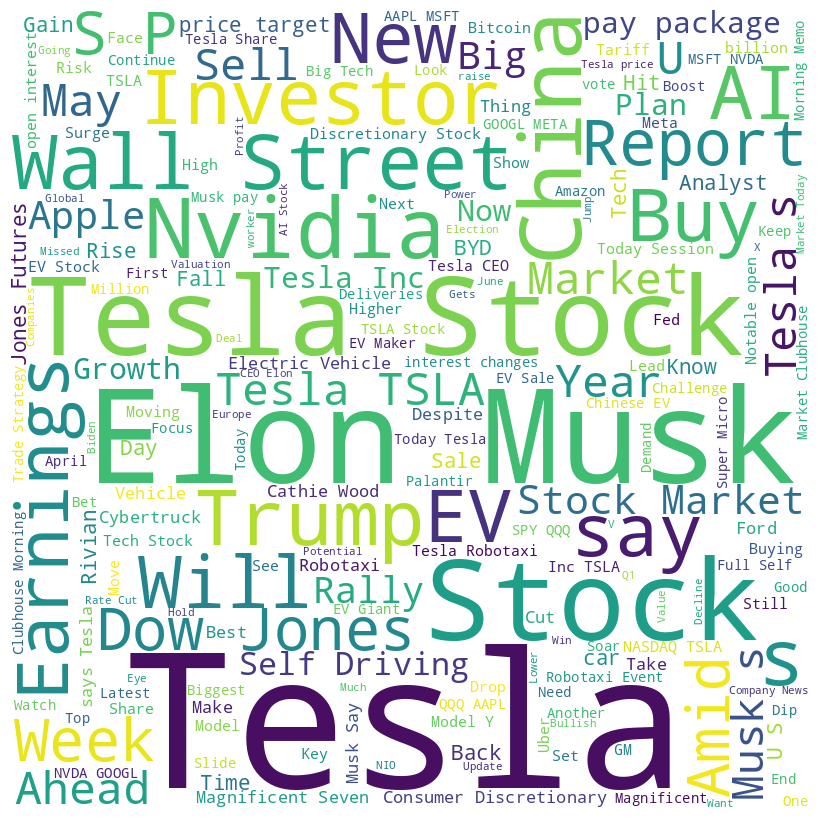

In [65]:
text = " ".join(review for review in tesla_finn_news.headline.astype(str))

# Create and generate a word cloud image:
wordcloud = WordCloud(width=800, height=800,
                      background_color='white',
                      min_font_size=10).generate(text)

# Display the generated image:
plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()


--2025-03-25 18:43:04--  https://raw.githubusercontent.com/sg2083/independent_study/refs/heads/main/multiTimeline.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 797 [text/plain]
Saving to: ‘multiTimeline.csv’

multiTimeline.csv   100%[===================>]     797  --.-KB/s    in 0s      

2025-03-25 18:43:04 (60.5 MB/s) - ‘multiTimeline.csv’ saved [797/797]



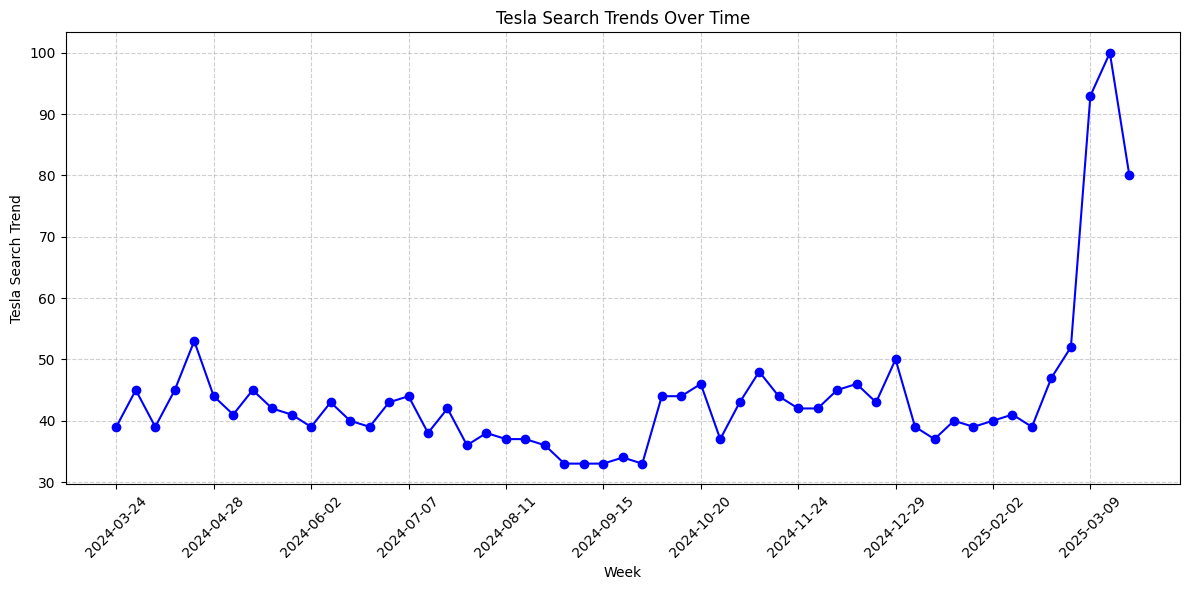

In [66]:
# Load dataset
!wget https://raw.githubusercontent.com/sg2083/independent_study/refs/heads/main/multiTimeline.csv -O multiTimeline.csv
df = pd.read_csv('multiTimeline.csv', skiprows=2)

# Convert 'Week' column to datetime format
df['Week'] = pd.to_datetime(df['Week'])

# Plot
plt.figure(figsize=(12, 6))  # Adjust figure size

plt.plot(df['Week'], df['tesla: (United States)'], color='blue', marker='o', linestyle='-')

# Improve x-axis labels
plt.xticks(df['Week'][::len(df)//10].dt.strftime('%Y-%m-%d'), rotation=45)  # Show only ~10 labels

# Labels and title
plt.xlabel('Week')
plt.ylabel('Tesla Search Trend')
plt.title('Tesla Search Trends Over Time')

# Add grid for better readability
plt.grid(True, linestyle='--', alpha=0.6)

# Improve layout
plt.tight_layout()

# Show plot
plt.show()


In [67]:
# Download VADER Lexicon
nltk.download('vader_lexicon')

# Load the processed news data
csv_filename = "tesla_finn_news.csv"
news_df = pd.read_csv(csv_filename)

# Ensure datetime column is in the correct format
news_df['datetime'] = pd.to_datetime(news_df['datetime']).dt.strftime('%Y-%m-%d')

# Initialize Sentiment Analyzer
sia = SentimentIntensityAnalyzer()

# Function to get sentiment scores
def get_sentiment(text):
    sentiment = sia.polarity_scores(text)
    return sentiment['compound']

# Apply sentiment analysis using only headlines
news_df['headline_sentiment'] = news_df['headline'].apply(get_sentiment)
news_df['final_sentiment'] = news_df['headline_sentiment']

# Save updated data
news_df.to_csv("tesla_finn_news_sentiment.csv", index=False)
print("Sentiment analysis (headline only) completed and saved successfully.")

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


Sentiment analysis (headline only) completed and saved successfully.


In [68]:
# Load the processed news data with sentiment scores
csv_filename = "tesla_finn_news_sentiment.csv"
news_df = pd.read_csv(csv_filename)

# Ensure datetime column is in the correct format
news_df['datetime'] = pd.to_datetime(news_df['datetime']).dt.strftime('%Y-%m-%d')

# Aggregate sentiment scores per day
aggregated_sentiment = news_df.groupby('datetime')['final_sentiment'].mean().reset_index()
aggregated_sentiment.rename(columns={'datetime': 'Date', 'final_sentiment': 'average_sentiment'}, inplace=True)

# Save the aggregated sentiment data
aggregated_csv_filename = "tesla_aggregated_sentiment.csv"
aggregated_sentiment.to_csv(aggregated_csv_filename, index=False)

print("Aggregated sentiment scores per day saved successfully.")

Aggregated sentiment scores per day saved successfully.


In [69]:
# Load the aggregated sentiment data
sentiment_filename = "tesla_aggregated_sentiment.csv"
sentiment_df = pd.read_csv(sentiment_filename)

# Load the Tesla stock data
tesla_stock_filename = "tesla_data.csv"
tesla_df = pd.read_csv(tesla_stock_filename)

# Ensure date columns are in the correct format
sentiment_df['Date'] = pd.to_datetime(sentiment_df['Date'])
tesla_df['Date'] = pd.to_datetime(tesla_df['Date'])

# Merge sentiment data with Tesla stock data on 'Date'
merged_df = pd.merge(tesla_df, sentiment_df, on='Date', how='left')

# Save the merged dataset
merged_csv_filename = "tesla_sentiment_stock.csv"
merged_df.to_csv(merged_csv_filename, index=False)

print("Merged sentiment data with Tesla stock prices successfully saved.")


Merged sentiment data with Tesla stock prices successfully saved.


In [70]:
print(merged_df.head(5))

        Date        Open        High         Low       Close     Volume  \
0 2024-03-25  168.759995  175.240005  168.729996  172.630005   74228600   
1 2024-03-26  178.580002  184.250000  177.380005  177.669998  113186200   
2 2024-03-27  181.410004  181.910004  176.000000  179.830002   81804000   
3 2024-03-28  177.449997  179.570007  175.300003  175.789993   77654800   
4 2024-04-01  176.169998  176.750000  170.210007  175.220001   81562100   

   Dividends  Stock Splits  average_sentiment  
0        0.0           0.0          -0.025788  
1        0.0           0.0           0.120741  
2        0.0           0.0           0.053813  
3        0.0           0.0           0.100821  
4        0.0           0.0           0.116419  


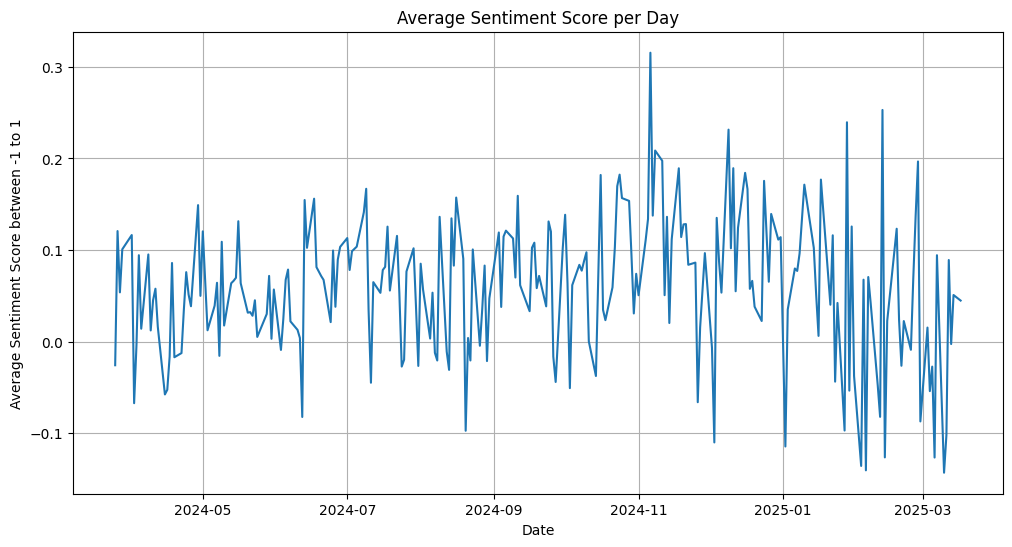

In [76]:
# prompt: plot average sentiment score per day from merged_df

import matplotlib.pyplot as plt

# Assuming merged_df is your DataFrame
# Load the merged data
merged_df = pd.read_csv("tesla_sentiment_stock.csv")
merged_df['Date'] = pd.to_datetime(merged_df['Date'])

# Group by date and calculate average sentiment
average_sentiment_per_day = merged_df.groupby('Date')['average_sentiment'].mean()

# Plot
plt.figure(figsize=(12, 6))
plt.plot(average_sentiment_per_day.index, average_sentiment_per_day.values)
plt.xlabel('Date')
plt.ylabel('Average Sentiment Score between -1 to 1')
plt.title('Average Sentiment Score per Day')
plt.grid(True)
plt.show()


<ipython-input-72-c1349c501560>:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sentiment_counts = sentiment_df.groupby('sentiment_group')['average_sentiment'].count()


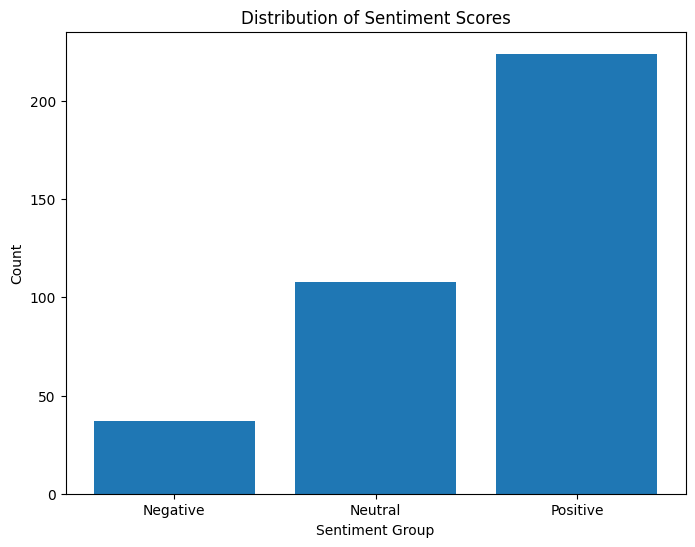

In [72]:
# Load the aggregated sentiment data
sentiment_filename = "tesla_aggregated_sentiment.csv"
sentiment_df = pd.read_csv(sentiment_filename)

# Define bins for sentiment groups
bins = [-1, -0.05, 0.05, 1]
labels = ['Negative', 'Neutral', 'Positive']

# Categorize sentiment scores into groups
sentiment_df['sentiment_group'] = pd.cut(sentiment_df['average_sentiment'], bins=bins, labels=labels, include_lowest=True)

# Group by sentiment group and count occurrences
sentiment_counts = sentiment_df.groupby('sentiment_group')['average_sentiment'].count()

# Plot bar graph
plt.figure(figsize=(8, 6))
plt.bar(sentiment_counts.index, sentiment_counts.values)
plt.xlabel('Sentiment Group')
plt.ylabel('Count')
plt.title('Distribution of Sentiment Scores')
plt.show()


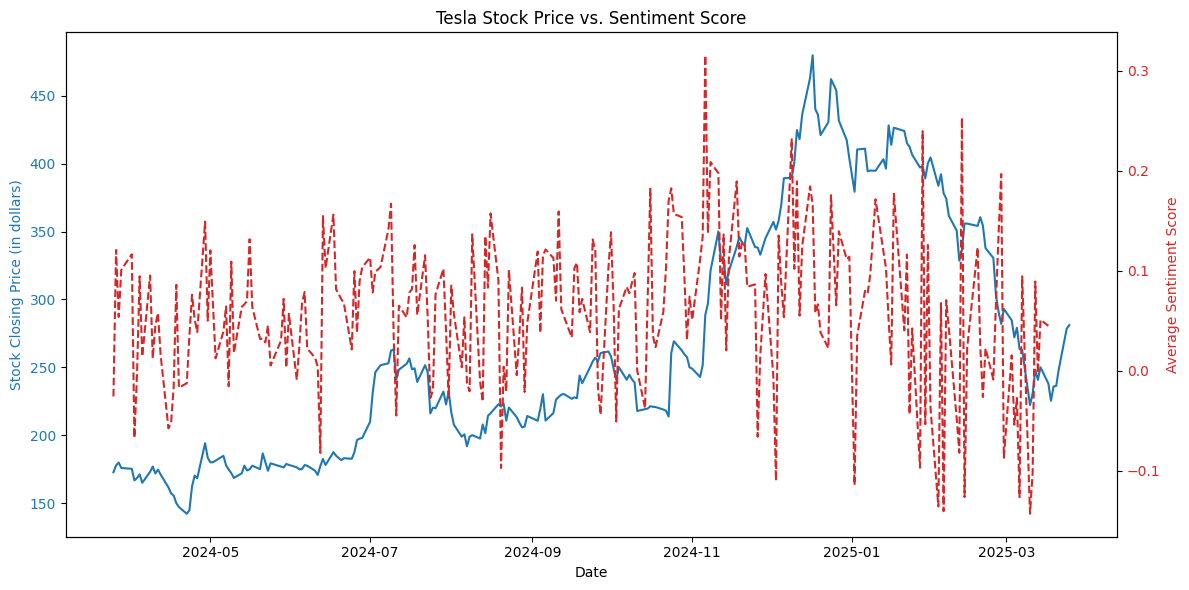

In [73]:
# Ensure 'Date' is in datetime format
merged_df['Date'] = pd.to_datetime(merged_df['Date'])

# Sort by Date
merged_df.sort_values(by='Date', inplace=True)

# Plot sentiment vs. closing price
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot stock closing price
ax1.set_xlabel('Date')
ax1.set_ylabel('Stock Closing Price (in dollars)', color='tab:blue')
ax1.plot(merged_df['Date'], merged_df['Close'], color='tab:blue', label='Close Price')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Create second y-axis for sentiment score
ax2 = ax1.twinx()
ax2.set_ylabel('Average Sentiment Score', color='tab:red')
ax2.plot(merged_df['Date'], merged_df['average_sentiment'], color='tab:red', linestyle='dashed', label='Sentiment Score')
ax2.tick_params(axis='y', labelcolor='tab:red')

# Add title and legend
plt.title("Tesla Stock Price vs. Sentiment Score")
fig.tight_layout()
plt.show()


#### Understanding the relationship between Sentiment Scores and stock prices
Ordinary Least Squares (OLS) regression is used to study the relationship between a dependent variable (Tesla’s stock price) and an independent variable (sentiment score). It finds the best-fitting line by minimizing the differences between actual and predicted values.

For this analysis, I used OLS to see if sentiment data (from news and social media) can help predict Tesla’s stock price.

Before applying OLS, I calculated the Pearson correlation coefficient to check if there is a relationship between sentiment and stock price.

Pearson Correlation: 0.1367, P-value: 0.0325


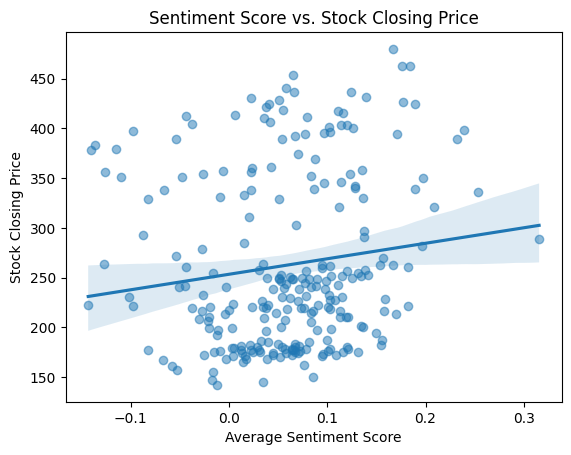

                            OLS Regression Results                            
Dep. Variable:                  Close   R-squared:                       0.019
Model:                            OLS   Adj. R-squared:                  0.015
Method:                 Least Squares   F-statistic:                     4.626
Date:                Tue, 25 Mar 2025   Prob (F-statistic):             0.0325
Time:                        18:43:12   Log-Likelihood:                -1436.2
No. Observations:                 245   AIC:                             2876.
Df Residuals:                     243   BIC:                             2883.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const               253.2878      6.94

In [74]:
# Drop rows with missing sentiment scores
merged_df = merged_df.dropna(subset=['average_sentiment'])

# Calculate Pearson correlation coefficient
correlation, p_value = pearsonr(merged_df['average_sentiment'], merged_df['Close'])
print(f"Pearson Correlation: {correlation:.4f}, P-value: {p_value:.4f}")

# Scatter plot with regression line
sns.regplot(x=merged_df['average_sentiment'], y=merged_df['Close'], scatter_kws={'alpha':0.5})
plt.xlabel("Average Sentiment Score")
plt.ylabel("Stock Closing Price")
plt.title("Sentiment Score vs. Stock Closing Price")
plt.show()

# Perform Linear Regression
X = merged_df[['average_sentiment']]
X = sm.add_constant(X)  # Add constant for intercept
Y = merged_df['Close']
model = sm.OLS(Y, X).fit()
print(model.summary())


Pearson Coefficient Results:
- Pearson correlation = 0.1367
- p-value = 0.0325

> The correlation is positive but weak (closer to 0 than 1). The p-value is below 0.05, meaning the correlation is statistically significant.

Let's analyze the OLS regression results to measure the exact impact of sentiment on stock price.

| Metric                  | Value   | Meaning                                                      |
|-------------------------|--------|--------------------------------------------------------------|
| **R-squared**           | 0.019   | Sentiment explains only **1.9%** of stock price changes.    |
| **p-value for Sentiment** | 0.032   | Sentiment has a **statistically significant** impact on stock price. |
| **Sentiment Coefficient** | 155.91  | A **1-unit increase** in sentiment score is linked to a **$155.91 increase** in stock price. |


- Sentiment has a significant but weak impact

- The OLS regression confirms that sentiment has a small but statistically significant effect.

- R² = 0.019 shows that sentiment alone is not enough to predict stock prices.

Other factors like market trends, trading volume, and economic indicators could also be included.

#### Random Forest Regression Analysis of Stock Prices

Random Forest builds multiple decision trees and combines their results to improve accuracy and reduce overfitting.

Given that OLS regression showed weak predictive power (R² = 0.019) and stock prices are affected by multiple factors, Random Forest is a better alternative to improve accuracy and capture non-linear relationship between stock prices and sentiment scores.

Random Forest Regression - MAE: 29.3319, MSE: 1344.9776, RMSE: 36.6739, R² Score: 0.8175


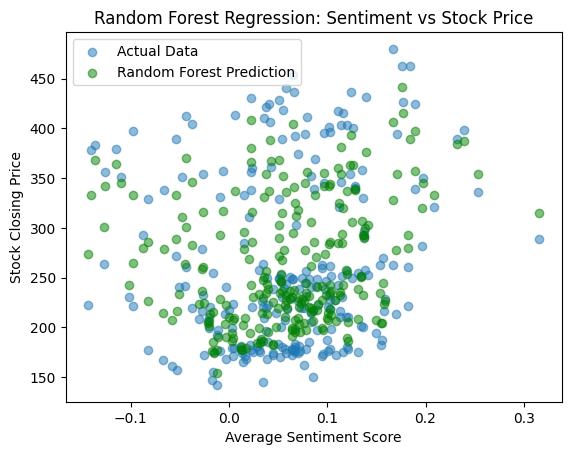

In [75]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Define and train the model
rf_reg = RandomForestRegressor(n_estimators=100, random_state=42)
rf_reg.fit(X, Y)

# Predictions
Y_pred_rf = rf_reg.predict(X)

# Evaluate model
mae_rf = mean_absolute_error(Y, Y_pred_rf)
mse_rf = mean_squared_error(Y, Y_pred_rf)
rmse_rf = np.sqrt(mse_rf)
r2_rf = r2_score(Y, Y_pred_rf)

print(f"Random Forest Regression - MAE: {mae_rf:.4f}, MSE: {mse_rf:.4f}, RMSE: {rmse_rf:.4f}, R² Score: {r2_rf:.4f}")

# Plot results
plt.scatter(X['average_sentiment'], Y, alpha=0.5, label="Actual Data")
plt.scatter(X['average_sentiment'], Y_pred_rf, color='green', alpha=0.5, label="Random Forest Prediction")
plt.xlabel("Average Sentiment Score")
plt.ylabel("Stock Closing Price")
plt.title("Random Forest Regression: Sentiment vs Stock Price")
plt.legend()
plt.show()


#### Analyzing Random Forest Rgression Results

| Metric                     | Value  | Meaning                                              |
|----------------------------|--------|------------------------------------------------------|
| R-squared                 | 0.8175  | Model explains 81.75% of stock price variations.     |
| Mean Absolute Error (MAE)  | 29.33  | On average, the prediction is $29.33 off from the actual price. |
| Mean Squared Error (MSE)   | 1344.98  | Measures error magnitude (lower is better).         |
| Root Mean Squared Error (RMSE) | 36.67  | The model’s average prediction error is 36.67.    |

- R² = 0.8175 means the model captures 81.75% of stock price fluctuations, significantly better than OLS. This suggests that sentiment scores have a strong non-linear relationship with stock prices, which Random Forest effectively models.
- MAE = 29.33 means the model's average absolute prediction error is around $29.
- RMSE = 36.67 confirms relatively small errors but suggests a few larger mispredictions (higher RMSE than MAE).

Limitation:
- MSE = 1344.98 is high, meaning some large errors exist in the predictions.


#### Next Steps:
- Using different sentiment analyzers for recalculating the sentiment scores and comparing their random-forest regression results
- Adding more predictors like 'trading volume' to further improve accuracy.

